<a href="https://colab.research.google.com/github/Saraeladham/Elevvo-Machine-Learning-Internship-Projects/blob/main/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Data Loading and insights

In [50]:
cust_data= pd.read_csv('/content/Mall_Customers.csv')

print(cust_data.shape)
print(cust_data.info())
cust_data.head()

(200, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


# EDA


In [51]:
cust_data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [52]:
cust_data.isnull().sum()

,0
CustomerID,0
Gender,0
Age,0
Annual Income (k$),0
Spending Score (1-100),0


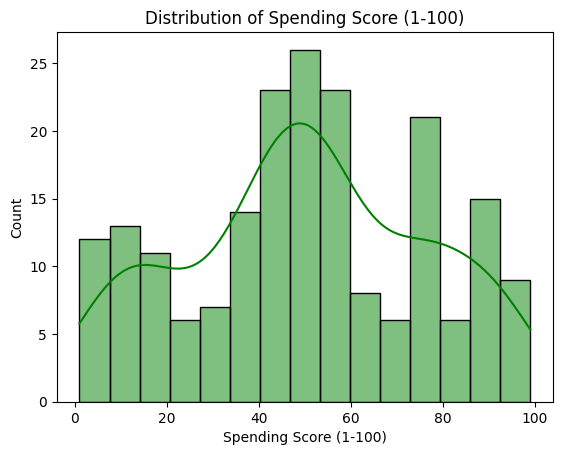

In [53]:
# Distribution of Spending Score
sns.histplot(data=cust_data, x='Spending Score (1-100)', bins=15, kde=True, color="green")
plt.title("Distribution of Spending Score (1-100)")
plt.show()

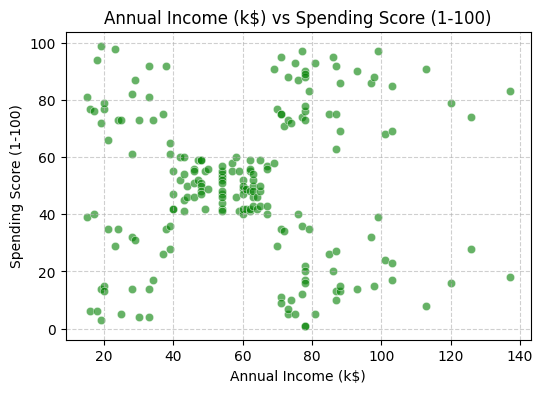

In [54]:
# Scatter plot: Income vs Spending
plt.figure(figsize=(6,4))
sns.scatterplot(data=cust_data, x="Annual Income (k$)", y="Spending Score (1-100)", color="Green", alpha=0.6)
plt.title("Annual Income (k$) vs Spending Score (1-100)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Data Preprocessing

Remove identifiers that do not carry meaningful signal. Encode categorical variables to numeric so clustering algorithms can use them.


KMeans uses Euclidean distance; features with larger numeric ranges dominate. StandardScaler centers features to mean 0 and scales to unit variance — a strong general solution.

In [55]:
# Drop unhelpful column
cust_data.drop(['CustomerID'], axis=1, inplace=True)

In [56]:
# Encode Gender
if 'Gender' in cust_data.columns:
    cust_data = pd.get_dummies(cust_data, columns=['Gender'], drop_first=False)

In [57]:
# Select features for clustering
features = cust_data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender_Female', 'Gender_Male']]


In [58]:
# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Choose K (Elbow + Silhouette)

Elbow shows diminishing returns in compactness (inertia). Silhouette measures cohesion vs separation and is more informative about real cluster separation.

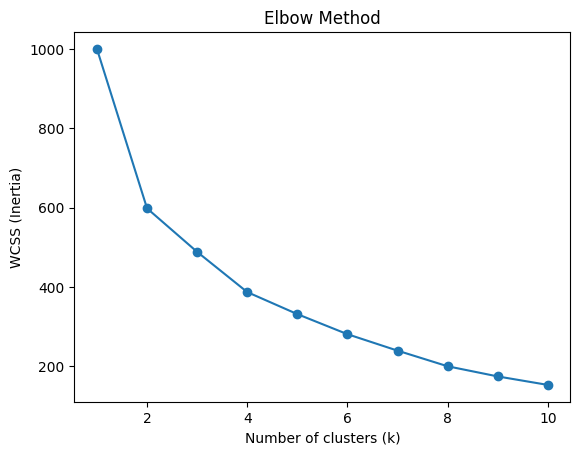

In [59]:
# Check for and handle NaN values before clustering
if np.isnan(scaled_features).any():
    print("Warning: scaled_features contains NaN values. Imputing with mean.")
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaled_features = imputer.fit_transform(scaled_features)

wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS (Inertia)")
plt.title("Elbow Method")
plt.show()

In [60]:
# Silhouette scores
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(scaled_features)
    score = silhouette_score(scaled_features, labels)
    print(f"k={k}, silhouette score={score:.3f}")

k=2, silhouette score=0.396
k=3, silhouette score=0.368
k=4, silhouette score=0.332
k=5, silhouette score=0.346
k=6, silhouette score=0.362
k=7, silhouette score=0.381
k=8, silhouette score=0.402
k=9, silhouette score=0.419
k=10, silhouette score=0.438


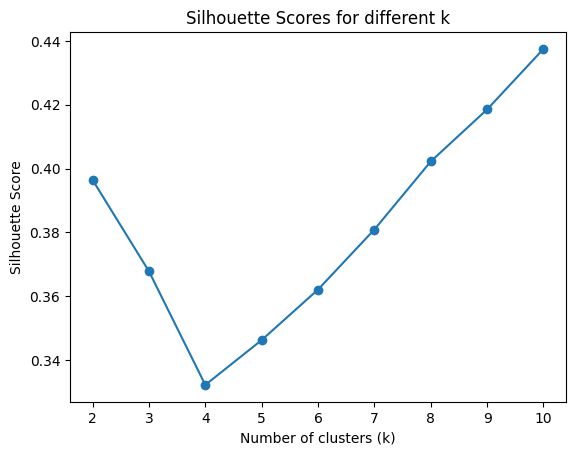

In [61]:
silhouette_scores = []
K = range(2, 11) # Iterate from 2 as silhouette score is not defined for k=1
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(scaled_features)
    silhouette_scores.append(silhouette_score(scaled_features, labels))

plt.plot(K, silhouette_scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for different k")
plt.show()

# Fitting KMeans

In [62]:
chosen_k = 4  # Adjust if elbow/silhouette suggest another value
kmeans = KMeans(n_clusters=chosen_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(scaled_features)

cust_data['Cluster'] = clusters

In [63]:
# Evaluation
sil_score = silhouette_score(scaled_features, clusters)
db_score = davies_bouldin_score(scaled_features, clusters)

print(f"Silhouette Score (k={chosen_k}): {sil_score:.3f}")
print(f"Davies-Bouldin Index (k={chosen_k}): {db_score:.3f}")


Silhouette Score (k=4): 0.332
Davies-Bouldin Index (k=4): 1.252


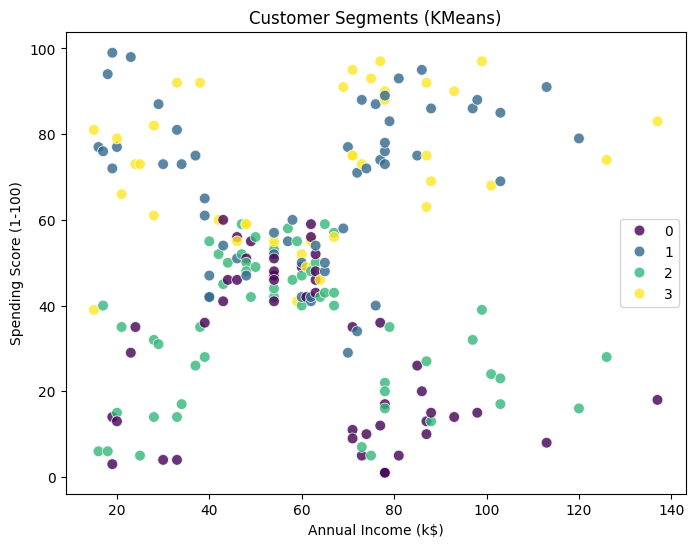

In [64]:
#Visualization (2D only)
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=cust_data,
    x='Annual Income (k$)',
    y='Spending Score (1-100)',
    hue='Cluster',
    palette='viridis',
    s=60,
    alpha=0.8
)
plt.title("Customer Segments (KMeans)")
plt.legend()
plt.show()

In [65]:
#Cluster Profiling
profile = cust_data.groupby('Cluster')[['Age','Annual Income (k$)','Spending Score (1-100)']].mean().round(2)
profile['Count'] = cust_data['Cluster'].value_counts().sort_index()
print(profile)

           Age  Annual Income (k$)  Spending Score (1-100)  Count
Cluster                                                          
0        49.44               62.42                   29.21     48
1        28.39               60.43                   68.18     56
2        47.80               58.07                   34.88     56
3        28.25               62.00                   71.68     40


# DBSCAN

In [66]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels = dbscan.fit_predict(scaled_features)

cust_data['DBSCAN_Cluster'] = labels

In [67]:
# Evaluation
if len(set(labels)) > 1:
    sil = silhouette_score(scaled_features, labels)
    dbi = davies_bouldin_score(scaled_features, labels)
    print(f"DBSCAN -> Silhouette: {sil:.3f}, DBI: {dbi:.3f}")
else:
    print("DBSCAN found only 1 cluster, cannot compute silhouette/DBI")


DBSCAN -> Silhouette: -0.014, DBI: 1.313


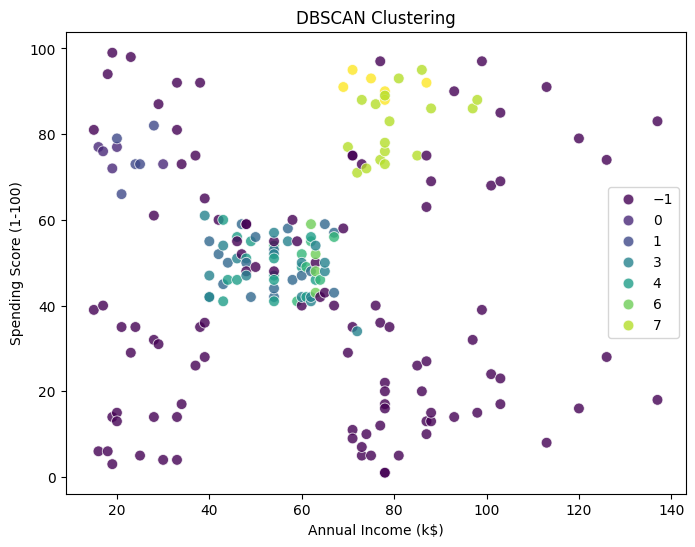

In [68]:
# Visualization
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=cust_data['Annual Income (k$)'],
    y=cust_data['Spending Score (1-100)'],
    hue=labels,
    palette='viridis',
    s=60,
    alpha=0.8
)
plt.title("DBSCAN Clustering")
plt.show()

In [69]:
avg_spending = cust_data.groupby('Cluster')['Spending Score (1-100)'].mean()
print(avg_spending)


Cluster
0    29.208333
1    68.178571
2    34.875000
3    71.675000
Name: Spending Score (1-100), dtype: float64


In [70]:
cluster_summary = cust_data.groupby('Cluster').agg({
    'Age': 'mean',
    'Annual Income (k$)': 'mean',
    'Spending Score (1-100)': 'mean'
}).round(2)

print(cluster_summary)


           Age  Annual Income (k$)  Spending Score (1-100)
Cluster                                                   
0        49.44               62.42                   29.21
1        28.39               60.43                   68.18
2        47.80               58.07                   34.88
3        28.25               62.00                   71.68
